In [57]:
from box import Box
import yaml
import matplotlib.pyplot as plt
import numpy as np
from pyts.classification import LearningShapelets
from pyts.datasets import load_gunpoint
from pyts.utils import windowed_view
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import classification_report
import pickle
from scipy.signal import stft
from sklearn import metrics
%matplotlib inline

In [58]:
path = "./data/erg_temp.xlsx"
signal_type = "Maximum 2.0 ERG Response"
columns = ["Age", "la", "a", "lb", "b", "diag"]
test_ratio = 0.3
save_path = "./saved_models"


In [59]:
def prepared_data():
    data = pd.read_excel(path, sheet_name=0)
    data.head()
    signal_type = "Maximum 2.0 ERG Response"
    new_data = pd.DataFrame()
    for i in range(7):
        row = data.iloc[i, :].values
        new_data[row[0]] = row[1:]
    new_data["signal_type"] = signal_type
    new_data["signal"] = [data[col].values[9:210].tolist() for col in data.columns[1:]]
    new_data["Diagnosis"] = new_data["Diagnosis"].map({"healthy": 0, "unhealthy": 1})
    new_data = new_data.dropna(axis=0)
    return new_data

In [60]:
def get_class_distribution(y):
    return np.unique(y, return_counts=True)

,PatNo,Age,Diagnosis,a-wave latency (la),a-wave amplitude (a),b-wave latency (lb),b-wave amplitude (b),signal_type,signal
0,3,27.86,1,20.5,51.602914,41,71.141256,Maximum 2.0 ERG Response,"[3.71e-06, 3.66e-06, 3.6e-06, 3.53e-06, 3.45e-..."
1,3,27.86,0,18.5,45.458349,40,83.424715,Maximum 2.0 ERG Response,"[-2.35, -2.47, -2.63, -2.8, -3.01, -3.24, -3.4..."
2,5,37.11,1,19,34.029953,37.5,52.252863,Maximum 2.0 ERG Response,"[1.26e-05, 1.24e-05, 1.22e-05, 1.2e-05, 1.18e-..."
3,6,31.68,1,19,113.258301,41,196.823552,Maximum 2.0 ERG Response,"[-10.8, -11.1, -11.5, -11.9, -12.4, -12.9, -13..."
4,6,31.69,1,19.5,46.341539,41,78.289791,Maximum 2.0 ERG Response,"[1.15e-06, 9.6e-07, 7.46e-07, 5.06e-07, 2.44e-..."


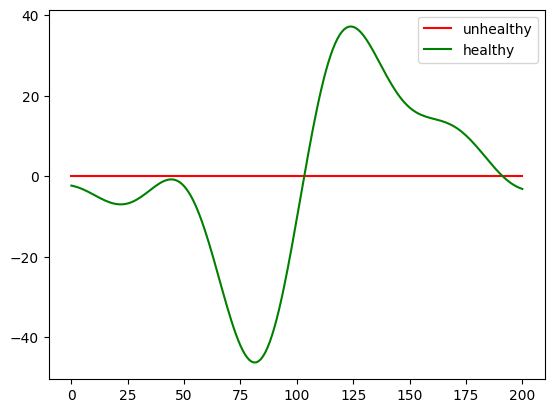

In [61]:
new_data = prepared_data()
plt.plot(new_data["signal"].values[0], color="r", label="unhealthy")
plt.plot(new_data["signal"].values[1], color="g", label="healthy")
plt.legend()
new_data.head()


In [62]:
new_data = new_data.dropna()

In [63]:
def pickle_load(path):
    with open(path, "rb") as f:
        return pickle.load(f)
    
shapelet_data = pickle_load("data/shaplet_distances100.pkl")
shapelet_data = shapelet_data.dropna()
shapelet_data.head()

,shapelet_0,shapelet_1,shapelet_2,shapelet_3,shapelet_4,shapelet_5,shapelet_6,shapelet_7,shapelet_8,shapelet_9,...,shapelet_90,shapelet_91,shapelet_92,shapelet_93,shapelet_94,shapelet_95,shapelet_96,shapelet_97,shapelet_98,shapelet_99
0,10635.297436,6713.907574,5258.145912,4914.983959,60.927561,103.068262,0.000206,20.947012,0.001132,17.428648,...,851.885265,676.168467,2210.874844,663.347953,1696.928545,306.097047,749.992208,817.474333,648.239046,460.528582
1,3682.228109,2406.399970,1074.114636,863.358499,78.688769,40.484768,39.735194,28.297938,22.936377,4.317285,...,7.936636,52.317386,21.692817,34.187063,3.557044,253.523244,0.335338,2.062762,64.763301,175.526265
2,10635.300536,6713.909473,5258.148009,4914.986014,60.927624,103.068294,0.000206,20.947013,0.001132,17.428755,...,851.885436,676.169127,2210.876259,663.348121,1696.929763,306.097326,749.992384,817.474542,648.239669,460.528985
3,53.952244,12.053155,197.579934,128.697364,805.588177,743.226515,492.272721,296.325087,203.465095,107.999618,...,561.491697,221.833712,655.146771,18.405754,237.338543,945.629058,5.575541,50.194846,154.342076,117.163703
4,10635.297110,6713.907365,5258.145693,4914.983739,60.927446,103.068185,0.000206,20.947001,0.001132,17.428636,...,851.884935,676.168391,2210.874697,663.347644,1696.928416,306.096940,749.991886,817.473935,648.238979,460.528475


In [64]:
shapelet_data.isna().sum()

shapelet_0     0
shapelet_1     0
shapelet_2     0
shapelet_3     0
shapelet_4     0
              ..
shapelet_95    0
shapelet_96    0
shapelet_97    0
shapelet_98    0
shapelet_99    0
Length: 100, dtype: int64

In [71]:
# add other parameters
# add other parameters
def au_pr_curve(ytrue, ypred):
    precision, recall, threshold = metrics.precision_recall_curve(ytrue, ypred, pos_label = 1)
    return metrics.auc(recall, precision)

def train_kfold(model, X, y, X_train, y_train, kfolds, random_state):
    sss = StratifiedShuffleSplit(n_splits=2, test_size=0.25, random_state=0)
    average_precisions = []
    
    for i, (train_index, test_index) in enumerate(sss.split(X, y)):        
        X_tr, X_te = X[train_index], X[test_index]
        y_tr, y_te = y[train_index], y[test_index]

        model.fit(X_tr, y_tr)
        y_pr = model.predict_proba(X_te)[:,1]
        aps = average_precision_score(y_te, y_pr)
        average_precisions.append(aps)
    
    return model, np.mean(average_precisions)

def test(model, X_test, y_test):
    y_pred = model.predict(X_test)
    class_names = ["healthy", "unhealthy"]
    print(classification_report(y_test, y_pred, target_names=class_names), "\n")

def train(model, X, y, test_ratio=0.2, kfold_splits = 10, random_state = 42):
    # prepare data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=random_state)
    model, mean_precision = train_kfold(model, X, y, X_train, y_train, kfold_splits, random_state)

    y_pred_h = model.predict_proba(X_test[y_test == 0])[:, 1]
    y_test_h = y_test[y_test==0]
    precision, recall, thresholds = metrics.precision_recall_curve(y_test_h, y_pred_h, pos_label=0)
    au_pr = metrics.auc(recall, precision)
    plt.plot(recall, precision)
    plt.show()
    print("area under pr:", au_pr)
    # test model
    test(model, X_test, y_test)
    return au_pr

In [72]:
def get_shapelets(X, y, num_shapelets):
    # Load the data set and fit the classifier
    #clf = LearningShapelets(random_state=42, tol=0.01, class_weight="balanced")
    #clf.fit(X, y)
    with open("data/shaplet_transform_clf.pkl", "rb") as f:
        clf = pickle.load(f)
    
    # Select two shapelets
    coefs = clf.coef_[0]
    sorted_coefs = np.argsort(coefs)[::-1][:num_shapelets]
    distance_df = pd.DataFrame()
    for i, ind in enumerate(sorted_coefs):
        
        shapelets = np.asarray([clf.shapelets_[0, ind]])

        # Derive the distances between the time series and the shapelets
        shapelet_size = shapelets.shape[1]
#         print("shapelet size:", shapelet_size)
        X_window = windowed_view(X, window_size=shapelet_size, window_step=1)
        X_dist = np.mean(
            (X_window[:, :, None] - shapelets[None, :]) ** 2, axis=3).min(axis=1)
        distance_df["shapelet_" + str(i)] = X_dist.ravel()
    
    return distance_df, clf
    

In [67]:
def get_stft_features(signal, fs, nperseg):
    freq, time, zxx = stft(signal, fs, nperseg=nperseg)
    zxx_mag = np.abs(zxx).flatten().tolist()
    return freq, time, zxx_mag

def get_stft_X(df, other_cols, only_classic=False, fs = 1, nperseg=20):
    if only_classic:
        print("reutrning classic")
        return df[other_cols].values
    
    X = []
    for idx, row in df.iterrows():
        new_features = row[other_cols].values.tolist()
        signal = np.array(row['signal'])
        freq, time, stft_features = get_stft_features(signal, fs, nperseg)
        new_features.extend(stft_features)
        X.append(new_features)
    return np.array(X)
    


In [68]:
def train_classifier(model, new_data):
    columns = [] #['a-wave latency (la)','a-wave amplitude (a)','b-wave latency (lb)','b-wave amplitude (b)']
    fs = 1
    npersegs = np.linspace(5, 20, 5)
    for nperseg in npersegs:
        print('nperseg =', nperseg, '\n')
        y = new_data["Diagnosis"].values
        #new_data = new_data.drop(columns=["Diagnosis"])
        X = get_stft_X(new_data, columns, fs=fs, nperseg=nperseg)
        #model = RandomForestClassifier(n_jobs=-1, random_state=42)
        train(model, X, y)

In [69]:
def train_combined(model, new_data, nperseg=5, fs=1.0):
    columns = ['a-wave latency (la)','a-wave amplitude (a)','b-wave latency (lb)','b-wave amplitude (b)']
    
    y = new_data["Diagnosis"].values
    signals = new_data["signal"].values.tolist()
    X = get_stft_X(new_data, columns, only_classic=False, fs=fs, nperseg=nperseg)
    dist = get_shapelets(signals, y, 5)[0]
    X = np.concatenate((X, dist), axis=1)
    print(X.shape, dist.shape, X.shape)
    train(model, X, y)


In [24]:
from sklearn.datasets import load_iris
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

columns = []
fs = 1.0
nperseg = 5

y = new_data["Diagnosis"].values
X = get_stft_X(new_data, columns, only_classic=False, fs=fs, nperseg=nperseg)
# Define the parameter grid for each model
decision_tree_params = {
    'max_depth': [None, 3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

random_forest_params = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

logistic_regression_params = {
    'C': [0.1, 1.0, 10.0],
    'solver': ['liblinear', 'lbfgs']
}

svm_params = {
    'C': [0.1, 1.0, 10.0],
    'kernel': ['linear', 'rbf']
}

# Perform randomized grid search for each model
models = [
    ('Decision Tree', DecisionTreeClassifier(), decision_tree_params),
    ('Random Forest', RandomForestClassifier(), random_forest_params),
    ('Logistic Regression', LogisticRegression(), logistic_regression_params),
    ('SVM', SVC(), svm_params)
]

for model_name, model, params in models:
    print(f"Performing randomized grid search for {model_name}...")
    random_search = RandomizedSearchCV(model, params, n_jobs = 2, n_iter=20, cv=3, random_state=42)
    random_search.fit(X, y)
    best_params = random_search.best_params_
    print(f"Best parameters for {model_name}:")
    for param, value in best_params.items():
        print(f"{param}: {value}")
    print()


Performing randomized grid search for Decision Tree...


/proj/ciptmp/ez48awud/envs/erg/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for Decision Tree:
min_samples_split: 10
max_depth: 3

Performing randomized grid search for Random Forest...
Best parameters for Random Forest:
n_estimators: 50
min_samples_split: 5
max_depth: None

Performing randomized grid search for Logistic Regression...


/proj/ciptmp/ez48awud/envs/erg/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for Logistic Regression:
solver: liblinear
C: 1.0

Performing randomized grid search for SVM...


/proj/ciptmp/ez48awud/envs/erg/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for SVM:
kernel: linear
C: 0.1



(412, 209) (412, 5) (412, 209)


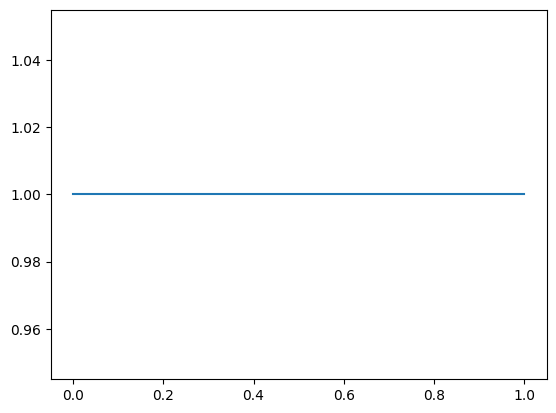

area under pr: 1.0
              precision    recall  f1-score   support

     healthy       1.00      0.82      0.90        11
   unhealthy       0.97      1.00      0.99        72

    accuracy                           0.98        83
   macro avg       0.99      0.91      0.94        83
weighted avg       0.98      0.98      0.97        83
 



In [25]:
model = RandomForestClassifier(class_weight="balanced", random_state=40)
train_combined(model,new_data)

In [16]:
y = new_data["Diagnosis"].values
signals = new_data["signal"].values.tolist()
X = get_stft_X(new_data, columns, only_classic=False, fs=fs, nperseg=nperseg)
dist = get_shapelets(signals, y, 5)[0]
X = np.concatenate((X, dist), axis=1)
random_forest_params = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced']
}

models = [
    ('Random Forest', RandomForestClassifier(), random_forest_params)
    
]

for model_name, model, params in models:
    print(f"Performing randomized grid search for {model_name}...")
    random_search = RandomizedSearchCV(model, params, n_jobs = 2, n_iter=20, cv=3, random_state=42)
    random_search.fit(X, y)
    best_params = random_search.best_params_
    print(f"Best parameters for {model_name}:")
    for param, value in best_params.items():
        print(f"{param}: {value}")
    print()

Performing randomized grid search for Random Forest...
Best parameters for Random Forest:
n_estimators: 50
min_samples_split: 5
max_depth: None
class_weight: balanced



nperseg = 5.0 



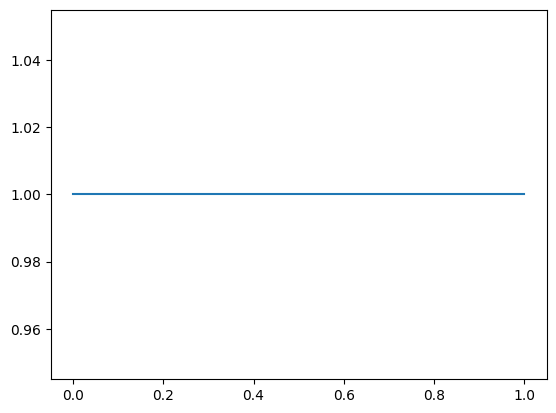

area under pr: 1.0
              precision    recall  f1-score   support

     healthy       0.82      0.82      0.82        11
   unhealthy       0.97      0.97      0.97        72

    accuracy                           0.95        83
   macro avg       0.90      0.90      0.90        83
weighted avg       0.95      0.95      0.95        83
 

nperseg = 8.75 



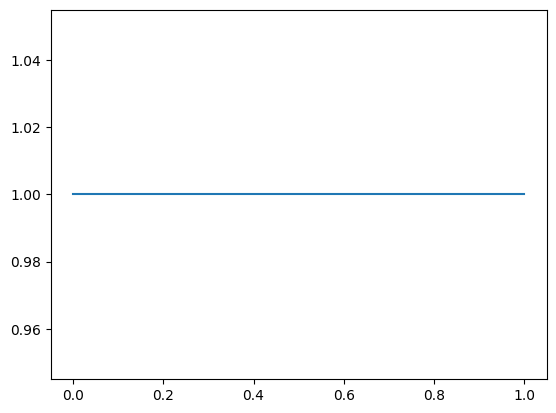

area under pr: 1.0
              precision    recall  f1-score   support

     healthy       1.00      0.82      0.90        11
   unhealthy       0.97      1.00      0.99        72

    accuracy                           0.98        83
   macro avg       0.99      0.91      0.94        83
weighted avg       0.98      0.98      0.97        83
 

nperseg = 12.5 



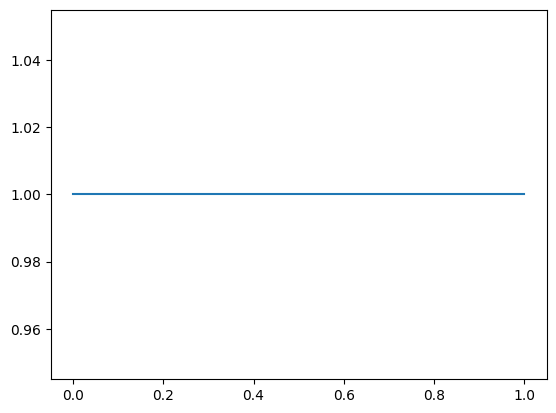

area under pr: 1.0
              precision    recall  f1-score   support

     healthy       0.90      0.82      0.86        11
   unhealthy       0.97      0.99      0.98        72

    accuracy                           0.96        83
   macro avg       0.94      0.90      0.92        83
weighted avg       0.96      0.96      0.96        83
 

nperseg = 16.25 



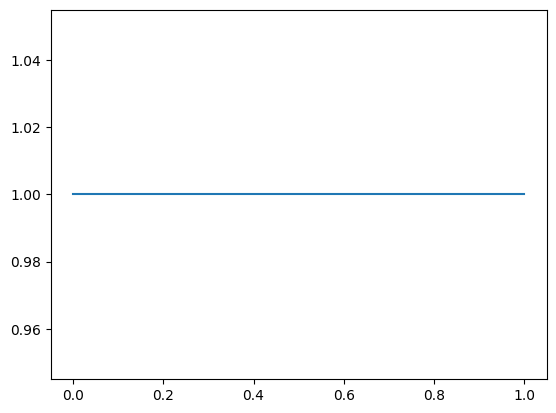

area under pr: 1.0
              precision    recall  f1-score   support

     healthy       0.82      0.82      0.82        11
   unhealthy       0.97      0.97      0.97        72

    accuracy                           0.95        83
   macro avg       0.90      0.90      0.90        83
weighted avg       0.95      0.95      0.95        83
 

nperseg = 20.0 



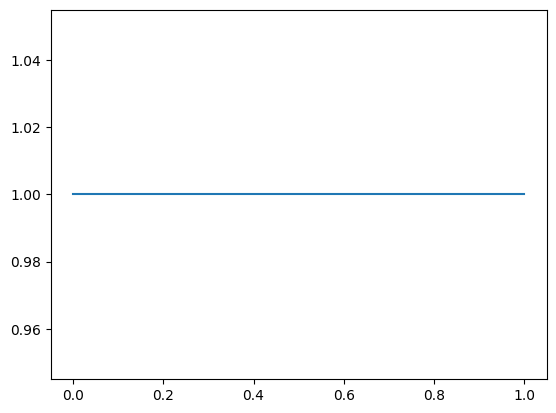

area under pr: 1.0
              precision    recall  f1-score   support

     healthy       0.75      0.82      0.78        11
   unhealthy       0.97      0.96      0.97        72

    accuracy                           0.94        83
   macro avg       0.86      0.89      0.87        83
weighted avg       0.94      0.94      0.94        83
 

nperseg = 5.0 



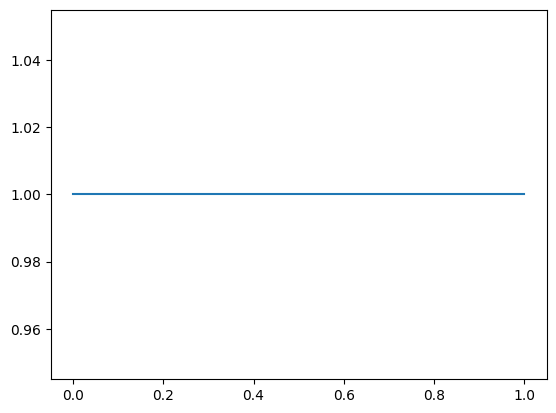

area under pr: 1.0
              precision    recall  f1-score   support

     healthy       1.00      0.82      0.90        11
   unhealthy       0.97      1.00      0.99        72

    accuracy                           0.98        83
   macro avg       0.99      0.91      0.94        83
weighted avg       0.98      0.98      0.97        83
 

nperseg = 8.75 



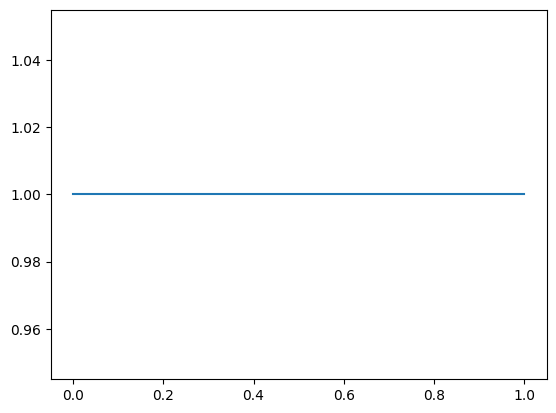

area under pr: 1.0
              precision    recall  f1-score   support

     healthy       1.00      0.82      0.90        11
   unhealthy       0.97      1.00      0.99        72

    accuracy                           0.98        83
   macro avg       0.99      0.91      0.94        83
weighted avg       0.98      0.98      0.97        83
 

nperseg = 12.5 



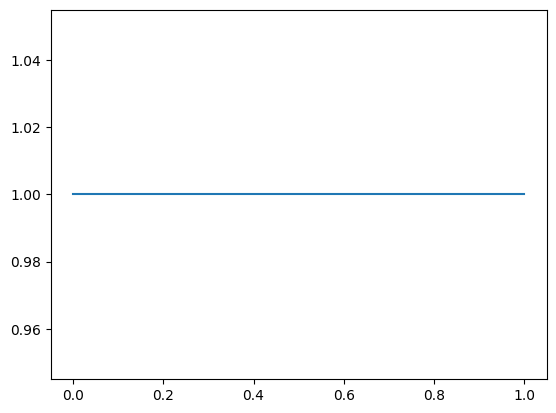

area under pr: 1.0
              precision    recall  f1-score   support

     healthy       1.00      0.82      0.90        11
   unhealthy       0.97      1.00      0.99        72

    accuracy                           0.98        83
   macro avg       0.99      0.91      0.94        83
weighted avg       0.98      0.98      0.97        83
 

nperseg = 16.25 



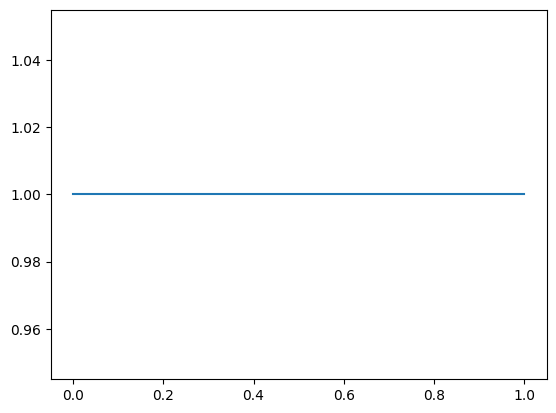

area under pr: 1.0
              precision    recall  f1-score   support

     healthy       1.00      0.82      0.90        11
   unhealthy       0.97      1.00      0.99        72

    accuracy                           0.98        83
   macro avg       0.99      0.91      0.94        83
weighted avg       0.98      0.98      0.97        83
 

nperseg = 20.0 



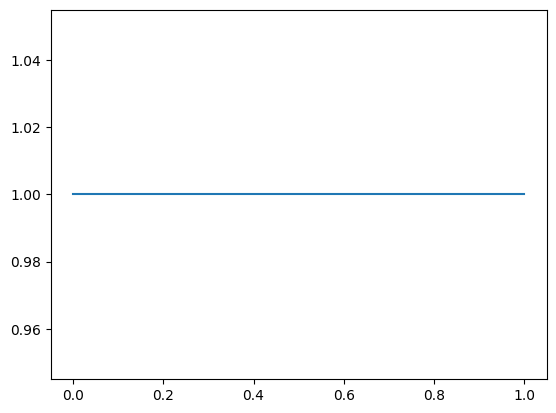

area under pr: 1.0
              precision    recall  f1-score   support

     healthy       1.00      0.82      0.90        11
   unhealthy       0.97      1.00      0.99        72

    accuracy                           0.98        83
   macro avg       0.99      0.91      0.94        83
weighted avg       0.98      0.98      0.97        83
 

nperseg = 5.0 



/proj/ciptmp/ez48awud/envs/erg/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/proj/ciptmp/ez48awud/envs/erg/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

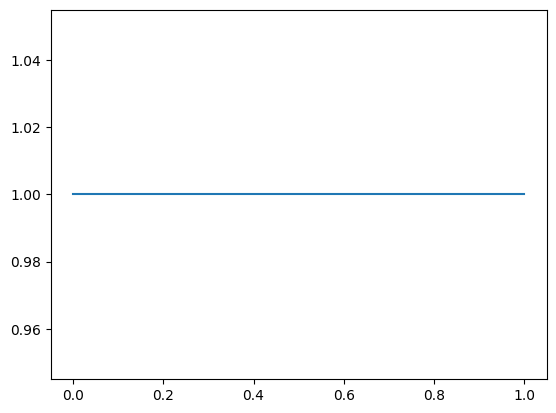

area under pr: 1.0
              precision    recall  f1-score   support

     healthy       1.00      0.27      0.43        11
   unhealthy       0.90      1.00      0.95        72

    accuracy                           0.90        83
   macro avg       0.95      0.64      0.69        83
weighted avg       0.91      0.90      0.88        83
 

nperseg = 8.75 



/proj/ciptmp/ez48awud/envs/erg/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/proj/ciptmp/ez48awud/envs/erg/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

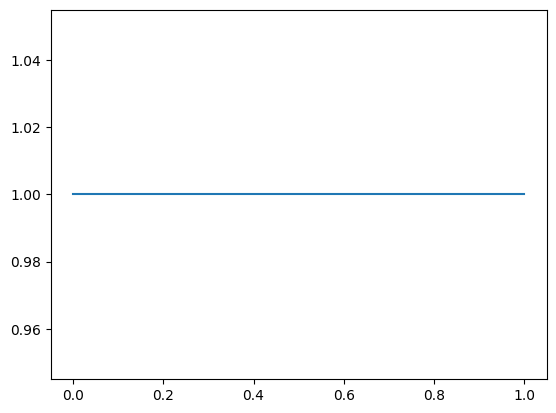

area under pr: 1.0
              precision    recall  f1-score   support

     healthy       1.00      0.27      0.43        11
   unhealthy       0.90      1.00      0.95        72

    accuracy                           0.90        83
   macro avg       0.95      0.64      0.69        83
weighted avg       0.91      0.90      0.88        83
 

nperseg = 12.5 



/proj/ciptmp/ez48awud/envs/erg/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/proj/ciptmp/ez48awud/envs/erg/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

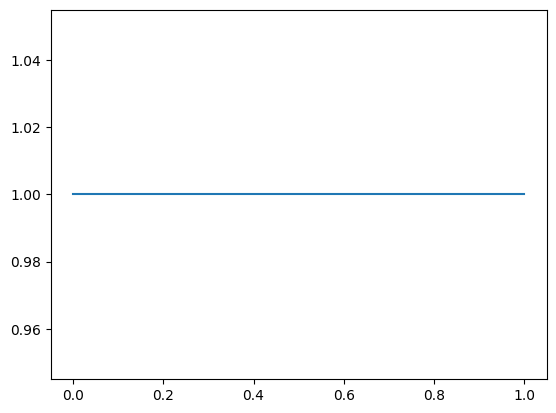

area under pr: 1.0
              precision    recall  f1-score   support

     healthy       1.00      0.27      0.43        11
   unhealthy       0.90      1.00      0.95        72

    accuracy                           0.90        83
   macro avg       0.95      0.64      0.69        83
weighted avg       0.91      0.90      0.88        83
 

nperseg = 16.25 



/proj/ciptmp/ez48awud/envs/erg/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/proj/ciptmp/ez48awud/envs/erg/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

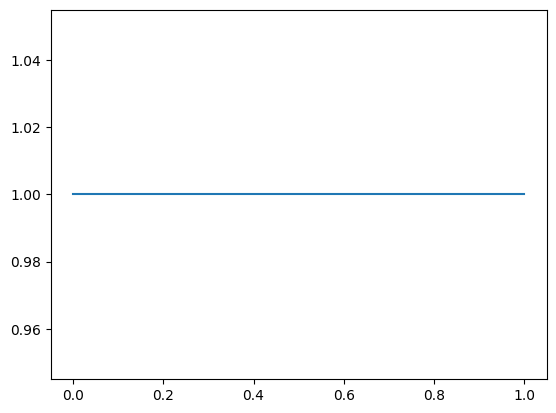

area under pr: 1.0
              precision    recall  f1-score   support

     healthy       1.00      0.27      0.43        11
   unhealthy       0.90      1.00      0.95        72

    accuracy                           0.90        83
   macro avg       0.95      0.64      0.69        83
weighted avg       0.91      0.90      0.88        83
 

nperseg = 20.0 



/proj/ciptmp/ez48awud/envs/erg/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/proj/ciptmp/ez48awud/envs/erg/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

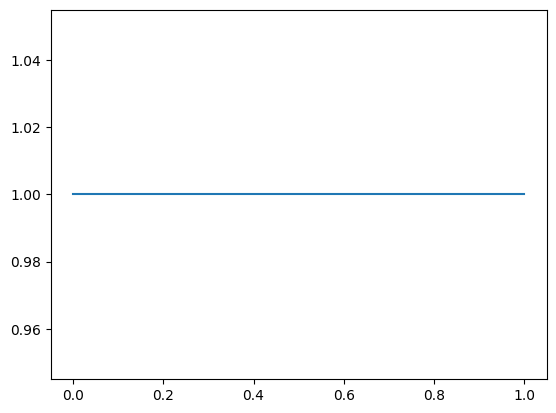

area under pr: 1.0
              precision    recall  f1-score   support

     healthy       1.00      0.27      0.43        11
   unhealthy       0.90      1.00      0.95        72

    accuracy                           0.90        83
   macro avg       0.95      0.64      0.69        83
weighted avg       0.91      0.90      0.88        83
 

nperseg = 5.0 



/proj/ciptmp/ez48awud/envs/erg/lib/python3.8/site-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


AttributeError: predict_proba is not available when  probability=False

In [73]:
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

models = [DecisionTreeClassifier(random_state=0), RandomForestClassifier(random_state=0),
             LogisticRegression(random_state=0), SVC(probability=0)]
for model in models:
    train_classifier(model, new_data)


In [18]:
### TO DOs ###
#1. try different window sizes
#2. add visualizations
#3. try with mean, mode, std features of each time frequency
# Precision recall curve for evaluation
# The precision recall plot is more informative than ROC plot when evaluation binary classificaion
# random forest, concatenate short time features and shapelet features

/proj/ciptmp/ez48awud/envs/erg/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/proj/ciptmp/ez48awud/envs/erg/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht